In [1]:
from lab1.drafts.scripts import *
import importlib
import numpy as np
from lab1.Lab1_FK_answers import *
from lab1.task2_inverse_kinematics import *
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

In [2]:
bvh = "..\\data\\general_simple.bvh"
joint_name, joint_parent, joint_offset = part1_calculate_T_pose(bvh)
motion_data = load_motion_data(bvh)
joint_positions, joint_orientations = part2_forward_kinematics(joint_name, joint_parent, joint_offset, motion_data, 0)

joint_name, joint_parent, joint_offset, joint_positions, joint_orientations

(['RootJoint', 'Link1', 'Link1_end', 'Link2', 'Link2_end'],
 [-1, 0, 1, 0, 3],
 array([[ 0.,  0.,  0.],
        [ 1.,  0.,  0.],
        [ 0.,  1.,  0.],
        [-1.,  0.,  0.],
        [ 0.,  0., -1.]]),
 array([[ 0.5,  0.5,  0.5],
        [ 1.5,  0.5,  0.5],
        [ 1.5,  1.5,  0.5],
        [-0.5,  0.5,  0.5],
        [-0.5,  0.5, -0.5]]),
 array([[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]]))

In [3]:
target = np.array([2., 2., 2.])

meta_data = MetaData(joint_name, joint_parent, joint_positions, 'Link2_end', 'Link1_end')
start2end, start2end_names, root_index = meta_data.get_path_from_root_to_end()
start2end, start2end_names, root_index

(array([4, 3, 0, 1, 2]),
 ['Link2_end', 'Link2', 'RootJoint', 'Link1', 'Link1_end'],
 2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


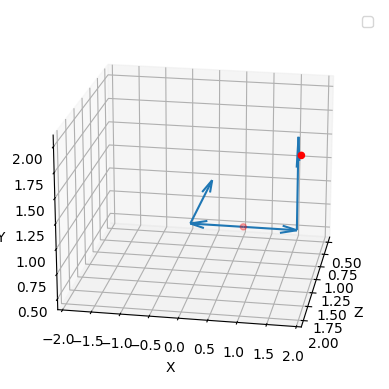

In [4]:
points = np.stack((target, joint_positions[0]))
plot_manipulator(joint_positions,
                   joint_parent,
                    start2end,
                   points, xlim=(-2, 2), ylim=(-2, 2), zlim=(-2, 2))

In [25]:
joint_positions, joint_positions[start2end[start2end != 0]], start2end

(array([[ 0.5,  0.5,  0.5],
        [ 1.5,  0.5,  0.5],
        [ 1.5,  1.5,  0.5],
        [-0.5,  0.5,  0.5],
        [-0.5,  0.5, -0.5]]),
 array([[-0.5,  0.5, -0.5],
        [-0.5,  0.5,  0.5],
        [ 1.5,  0.5,  0.5],
        [ 1.5,  1.5,  0.5]]),
 array([4, 3, 0, 1, 2]))

In [26]:
offsets = joint_positions[start2end[start2end != 0]][1:] - joint_positions[start2end[start2end != 0]][:-1]
offsets

array([[0., 0., 1.],
       [2., 0., 0.],
       [0., 1., 0.]])

In [27]:
jacobian_transpose = np.cross(np.eye(3), offsets[:, None, :]).reshape(-1, 3)
jacobian_transpose

array([[ 0., -1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0., -2.],
       [ 0.,  2.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  0.],
       [-1.,  0.,  0.]])

In [28]:
error = joint_positions[start2end[-1]] - target
print(f"end_position:\n{joint_positions[start2end[-1]]}\n"
      f"target:\n{target}\n"
      f"error = end_positions - target:\n{error}")

end_position:
[1.5 1.5 0.5]
target:
[2. 2. 2.]
error = end_positions - target:
[-0.5 -0.5 -1.5]


In [29]:
loss_gradient = jacobian_transpose @ error
loss_gradient

array([ 0.5, -0.5,  0. ,  0. ,  3. , -1. , -1.5,  0. ,  0.5])

In [30]:
learning_rate = 0.1
update = - learning_rate * loss_gradient
update

array([-0.05,  0.05, -0.  , -0.  , -0.3 ,  0.1 ,  0.15, -0.  , -0.05])

In [31]:
update.reshape(-1, 3)

array([[-0.05,  0.05, -0.  ],
       [-0.  , -0.3 ,  0.1 ],
       [ 0.15, -0.  , -0.05]])

In [32]:
rotations = R.from_euler("XYZ", update.reshape(-1, 3))
rotations.as_matrix()

array([[[ 9.98750260e-01,  2.16840434e-19,  4.99791693e-02],
        [-2.49791736e-03,  9.98750260e-01,  4.99167083e-02],
        [-4.99167083e-02, -4.99791693e-02,  9.97502083e-01]],

       [[ 9.50563786e-01, -9.53745058e-02, -2.95520207e-01],
        [ 9.98334166e-02,  9.95004165e-01,  0.00000000e+00],
        [ 2.94043837e-01, -2.95027919e-02,  9.55336489e-01]],

       [[ 9.98750260e-01,  4.99791693e-02, -4.33680869e-19],
        [-4.94179571e-02,  9.87535372e-01, -1.49438132e-01],
        [-7.46879372e-03,  1.49251374e-01,  9.88771078e-01]]])

In [33]:
new_offsets = rotations.apply(offsets)
new_offsets

array([[0.04997917, 0.04991671, 0.99750208],
       [1.90112757, 0.19966683, 0.58808767],
       [0.04997917, 0.98753537, 0.14925137]])

In [34]:
if root_index != -1:
    orientations = R.from_quat(joint_orientations[start2end[1:-1]])
else:
    orientations =  R.from_quat(joint_orientations[start2end[:-1]])

In [35]:
orientations.as_quat()

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [36]:
(orientations * rotations).as_quat()

array([[-2.49895846e-02,  2.49895846e-02, -6.24869803e-04,
         9.99375130e-01],
       [-7.46879372e-03, -1.49251374e-01,  4.94179571e-02,
         9.87535372e-01],
       [ 7.49062930e-02,  1.87304756e-03, -2.49271237e-02,
         9.96877213e-01]])

In [37]:
(rotations * orientations).as_quat()

array([[-2.49895846e-02,  2.49895846e-02, -6.24869803e-04,
         9.99375130e-01],
       [-7.46879372e-03, -1.49251374e-01,  4.94179571e-02,
         9.87535372e-01],
       [ 7.49062930e-02,  1.87304756e-03, -2.49271237e-02,
         9.96877213e-01]])

In [38]:
orientations *= rotations

In [39]:
orientations.as_quat()

array([[-2.49895846e-02,  2.49895846e-02, -6.24869803e-04,
         9.99375130e-01],
       [-7.46879372e-03, -1.49251374e-01,  4.94179571e-02,
         9.87535372e-01],
       [ 7.49062930e-02,  1.87304756e-03, -2.49271237e-02,
         9.96877213e-01]])

In [40]:
new_offsets

array([[0.04997917, 0.04991671, 0.99750208],
       [1.90112757, 0.19966683, 0.58808767],
       [0.04997917, 0.98753537, 0.14925137]])

In [41]:
np.cumsum(new_offsets, axis=0)

array([[0.04997917, 0.04991671, 0.99750208],
       [1.95110674, 0.24958354, 1.58558976],
       [2.00108591, 1.23711891, 1.73484113]])

In [42]:
joint_positions[start2end[0]]

array([-0.5,  0.5, -0.5])

In [43]:
joint_positions[start2end[0]][None], new_offsets

(array([[-0.5,  0.5, -0.5]]),
 array([[0.04997917, 0.04991671, 0.99750208],
        [1.90112757, 0.19966683, 0.58808767],
        [0.04997917, 0.98753537, 0.14925137]]))

In [44]:
np.concatenate((joint_positions[start2end[0]][None, :], new_offsets), axis=0)

array([[-0.5       ,  0.5       , -0.5       ],
       [ 0.04997917,  0.04991671,  0.99750208],
       [ 1.90112757,  0.19966683,  0.58808767],
       [ 0.04997917,  0.98753537,  0.14925137]])

In [45]:
test_positions = np.cumsum(np.concatenate((joint_positions[start2end[0]][None, :], new_offsets), axis=0), axis=0)
test_positions

array([[-0.5       ,  0.5       , -0.5       ],
       [-0.45002083,  0.54991671,  0.49750208],
       [ 1.45110674,  0.74958354,  1.08558976],
       [ 1.50108591,  1.73711891,  1.23484113]])

In [14]:
offsets = joint_positions[start2end[start2end != 0]][1:] - joint_positions[start2end[start2end != 0]][:-1]

to_root = joint_positions[0] - joint_positions[start2end[root_index - 1]]

jacobian_transpose = np.cross(np.eye(3), offsets[:, None, :]).reshape(-1, 3)

error = joint_positions[start2end[-1]] - target

loss_gradient = jacobian_transpose @ error

learning_rate = 0.1
update = - learning_rate * loss_gradient

rotations = R.from_euler("XYZ", update.reshape(-1, 3))

new_offsets = rotations.apply(offsets)

joint_orientations = R.from_quat(joint_orientations)
if root_index != -1:
    orientations = joint_orientations[start2end[1:-1]]
else:
    orientations = joint_orientations[start2end[:-1]]
    
orientations = rotations * orientations
to_root = rotations[root_index - 1].apply(to_root)

if root_index != -1:
    joint_orientations[start2end[1:-1]] = orientations
else:
    joint_orientations[start2end[:-1]] = orientations

test_positions = np.cumsum(np.concatenate((joint_positions[start2end[0]][None, :], new_offsets), axis=0), axis=0)

root = test_positions[root_index - 1] + to_root
joint_positions = pose_joint_positions(root, joint_parent, joint_offset, joint_orientations)

points = np.stack((target, joint_positions[0]))
plot_manipulator(joint_positions,
                   joint_parent,
                    start2end,
                   points, xlim=(-2, 2), ylim=(-2, 2), zlim=(-2, 2))

ValueError: setting an array element with a sequence.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


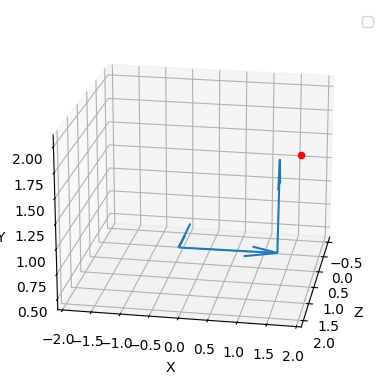

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.quiver(test_positions[:-1, 0],
          test_positions[:-1, 1],
          test_positions[:-1, 2],
          new_offsets[:, 0],
          new_offsets[:, 1],
          new_offsets[:, 2])

ax.scatter(target[0], target[1], target[2], c='r', marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim(-2, 2)
ax.set_xlim(-2, 2)
ax.set_xlim(-2, 2)
ax.legend()
ax.view_init(elev=20, azim=10, vertical_axis='y')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


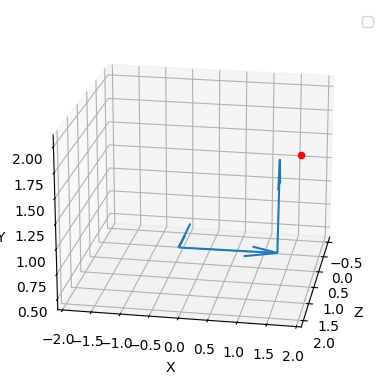

In [5]:
test_positions, new_offsets = gradient_descent(joint_positions, joint_orientations, root_index,
                 start2end, target, 0.1, 1, 0.01)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.quiver(test_positions[:-1, 0],
          test_positions[:-1, 1],
          test_positions[:-1, 2],
          new_offsets[:, 0],
          new_offsets[:, 1],
          new_offsets[:, 2])

ax.scatter(target[0], target[1], target[2], c='r', marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim(-2, 2)
ax.set_xlim(-2, 2)
ax.set_xlim(-2, 2)
ax.legend()
ax.view_init(elev=20, azim=10, vertical_axis='y')

In [47]:
# update offsets
# 
# compute new end effector position, with start fixed